problem: without time limit, all As got absorbed eventuallty.

In [ ]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,phic):
        L = 0.5
        rm=0.005
        voxel_radius = rm*1.021
        D = 1.
        kD = 4 * math.pi * (2 * rm) * D
        ka = kD * kaf
        dt = (4 * voxel_radius * voxel_radius) / (6 * D)    
        step=4000#int(L/rm/4)#*10000
        maxt=dt*step
        rng = GSLRandomNumberGenerator()  
        rng.seed(run)
        Nc=0#int(phic*L**3/(4*math.pi*rm**3 /3))
        with species_attributes():
            C | {'D':str(D),'radius':str(voxel_radius)}
            B | {'D':str(0),'radius':str(voxel_radius)}
            T | {'D':str(D),'radius':str(voxel_radius)}
        with reaction_rules():
            T + B >B | ka     
        m=get_model()           
        w = spatiocyte.SpatiocyteWorld(ones() * L, voxel_radius, rng)
        w.bind_to(m)       
        coord1 = w.position2coordinate(ones() * L * 0.5)
        coord2 = w.get_neighbor(coord1, 0)
        (pidB,p),suc=w.new_particle(Species('B'),w.coordinate2position(coord1))  
        (pidT,p),suc=w.new_particle(Species('T'),w.coordinate2position(coord2))     
        w.add_molecules(Species('C'),Nc)
        t= 0.0
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        pos = tuple(p.position())
        bound = voxel_radius*6
        while all(bound< dim <(L-bound) for dim in pos) and t<maxt:
            NT=w.num_particles(Species('T'))        
            if NT==0:
                return True
            else:
                (pid,p)=w.get_particle(pidT)
                pos = tuple(p.position())
                sim.step()
                t = sim.t()
        return t
    job.update({'run':task_id})
    out=singlerun(**job)
    return out


nproc=300
phic=0.1
kafs=[0.01]
simrun=int(500/kafs[0])
result=[('phic','kaf','pt','psim')]
for kaf in kafs:
    jobs=[{'kaf':kaf,'phic':phic}]
    res=ensemble.run_sge(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]
    #res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=10,modules=('numpy','ecell4','math'))[0]
    pt = 1./(1+1./kaf)
    print('kaf={},phic={},simrun={},Prebtotal_theory{:.3}'.format(kaf,phic,simrun,pt))
    print(len(res),simrun)
    psim = float(res.count(True))/simrun
    print('preb_sim',psim)  
    result.append((phic,kaf,pt,psim))
#f = open('3dcrowdingrebinding.txt','w')
#f.write(str(result))
#f.close()

DEBUG:sge:Your job-array 946160.1-50000:1 ("sge-lrkf_dtw.job") has been submitted
DEBUG:sge:job-ID  prior   name       user         state submit/start at     queue                          slots ja-task-ID 
DEBUG:sge:-----------------------------------------------------------------------------------------------------------------
DEBUG:sge: 946160 0.00000 sge-lrkf_d chew         qw    12/03/2017 13:05:30                                    1 1-50000:1
DEBUG:sge:
INFO:sge:Job 946160 must be queued, running or being transferred
INFO:sge:Waiting for jobids [946160] to finish
DEBUG:sge:job-ID  prior   name       user         state submit/start at     queue                          slots ja-task-ID 
DEBUG:sge:-----------------------------------------------------------------------------------------------------------------
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 1
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 65
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 66
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 67
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 68
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 69
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 70
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 71
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 72
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 136
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 137
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 138
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 139
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 140
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 141
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 142
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 143
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 207
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 208
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 209
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 210
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 211
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 212
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 213
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 214
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 278
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 279
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 280
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 281
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 282
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 283
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 284
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 285
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 45
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 46
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 47
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 48
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 49
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 50
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 51
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 52
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 116
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 117
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 118
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 119
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 120
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 121
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 122
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 123
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 187
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 188
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 189
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 190
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 191
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 192
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 193
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 194
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 258
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 259
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 260
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 261
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 262
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 263
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 264
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 265
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 25
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 26
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 27
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 28
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 29
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 30
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 31
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 32
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 96
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 97
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 98
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 99
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 100
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 101
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 102
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 103
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 1

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 167
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 168
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 169
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 170
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 171
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 172
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 173
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 174
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 238
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 239
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 240
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 241
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 242
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 243
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 244
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 245
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 4
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 5
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 6
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 7
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 8
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 9
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 10
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 11
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 75
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 76
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 77
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 78
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 79
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 80
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 81
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 82
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 146
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 147
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 148
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 149
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 150
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 151
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 152
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 153
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 217
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 218
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 219
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 220
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 221
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 222
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 223
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 224
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 288
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 289
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 290
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 291
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 292
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 293
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 294
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 295
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 55
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 56
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 57
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 58
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 59
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 60
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 61
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 62
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 126
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 127
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 128
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 129
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 130
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 131
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 132
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 133
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 197
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 198
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 199
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 200
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 201
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 202
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 203
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 204
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 268
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 269
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 270
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 271
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 272
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 273
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 274
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 275
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 35
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 36
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 37
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 38
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 39
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 40
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 41
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 42
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 106
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 107
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 108
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 109
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 110
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 111
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 112
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 113
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 177
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 178
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 179
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 180
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 181
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 182
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 183
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 184
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 13
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 14
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 15
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 16
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 17
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 18
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 19
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 20
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 84
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 85
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 86
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 87
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 88
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 89
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 90
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 91
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 155
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 156
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 157
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 158
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 159
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 160
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 161
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 162
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 295
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 296
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 297
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 298
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 299
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 300
DEBUG:sge: 946160 0.00000 sge-lrkf_d chew         qw    12/03/2017 13:05:30                                    1 301-50000:1
DEBUG:sge:
INFO:sge:Job 946160 must be queued, running or being transferred
INFO:sge:Waiting for jobids [946160] to finish
DEBUG:sge:job-ID  prior   name       user         

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 62
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 63
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 64
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 65
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 66
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 67
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 68
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 69
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 133
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 134
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 135
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 136
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 137
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 138
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 139
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 140
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 204
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 205
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 206
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 207
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 208
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 209
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 210
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 211
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 275
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 276
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 277
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 278
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 279
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 280
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 281
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 282
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 42
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 43
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 44
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 45
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 46
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 47
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 48
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 49
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 113
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 114
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 115
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 116
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 117
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 118
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 119
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 120
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 184
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 185
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 186
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 187
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 188
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 189
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 190
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 191
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 255
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 256
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 257
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 258
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 259
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 260
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 261
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 262
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 22
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 23
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 24
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 25
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 26
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 27
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 28
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 29
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 93
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 94
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 95
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 96
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 97
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 98
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 99
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 100
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:0

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 164
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 165
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 166
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 167
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 168
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 169
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 170
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 171
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 235
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 236
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 237
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 238
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 239
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 240
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 241
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 242
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 1
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 2
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 3
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 4
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 5
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 6
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 7
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 8
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 72
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 73
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 74
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 75
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 76
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 77
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 78
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 79
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 143
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 144
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 145
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 146
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 147
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc08                         1 148
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc02                         1 149
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 150
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 214
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 215
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 216
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 217
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 218
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 219
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 220
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 221
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 285
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 286
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 287
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 288
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 289
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 290
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 291
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 292
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 52
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 53
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc04                         1 54
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 55
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 56
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc13                         1 57
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc20                         1 58
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 59
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc12                         1 123
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc21                         1 124
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc15                         1 125
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc07                         1 126
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc25                         1 127
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc06                         1 128
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc23                         1 129
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 130
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc01                         1 194
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc19                         1 195
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc17                         1 196
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc26                         1 197
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc18                         1 198
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc11                         1 199
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc27                         1 200
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc28                         1 201
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc03                         1 265
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc10                         1 266
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 267
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc14                         1 268
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc24                         1 269
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 niina.q@ibc04                      1 270
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h1.q@ibc05                         1 271
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/2017 13:05:36 h2.q@ibc16                         1 272
DEBUG:sge: 946160 0.50000 sge-lrkf_d chew         r     12/03/20

In [2]:
import numpy as np
import os
import pickle
scores = {} # scores is an empty dict already
tmp="/home/chew/notebook/jupyter-notebook/tmp/"
namelist=np.array(os.listdir(tmp))
cnt=0
mean=[]
for n in namelist:
    if n[-6:]=='pickle': 
        target=tmp+n
        sz=os.path.getsize(target)
        if (sz>0):
            cnt+=1
            f=open(target ,"rb")
            unpickler = pickle.Unpickler(f)
            # if file is not empty scores will be equal
            # to the value unpickled
            scores = unpickler.load()
            mean.append(scores)
            #print(scores)    
print(cnt,mean.count(True))            
print(mean.count(True)/float(cnt)) 

49994 590
0.011801416169940394


In [36]:
result


In [23]:
#L=0.5,kaf=0.1
#phic=0.0
#kaf=0.1,phic=0.0,simrun=10000,Prebtotal_theory0.0909
#preb_sim 0.0922
phic=0.1
#kaf=0.1,phic=0.1,simrun=10000,Prebtotal_theory0.0909
#preb_sim 0.1047
ratio=0.1047/0.0922
print(ratio,1-phic/0.515,ratio*(1-phic/0.515))
phic=0.2
#kaf=0.1,phic=0.2,simrun=10000,Prebtotal_theory0.0909
#preb_sim 0.121
ratio=0.121/0.0922
print(ratio,1-phic/0.515,ratio*(1-phic/0.515))
phic=0.3
#kaf=0.1,phic=0.3,simrun=10000,Prebtotal_theory0.0909
#preb_sim 0.1455
ratio=0.1455/0.0922
print(ratio,1-phic/0.515,ratio*(1-phic/0.515))

1.1355748373101953 0.8058252427184466 0.9150748689004485
1.3123644251626898 0.6116504854368932 0.8027083377208685
1.5780911062906722 0.41747572815533984 0.6588147336941642


In [4]:
#L=0.5,kaf=0.05
#kaf=0.05,phic=0,simrun=20000,Prebtotal_theory0.0476
#preb_sim 0.0473
phic=0.1
preb_sim=0.05655
ratio=preb_sim/0.0476
print(ratio,ratio*(1-phic/0.515))

kaf=0.01
phic=0.1
preb_sim=0.0118
pt = 1./(1+1./kaf)
ratio=preb_sim/pt
print(pt,ratio, ratio*(1-phic/0.515))

1.1880252100840336 0.9573407032715999
0.009900990099009901 1.1918 0.9603825242718446


In [53]:
L=0.1
rm=0.005
voxel_radius = rm*1.021
D = 1.
dt = (4 * voxel_radius * voxel_radius) / (6 * D)    
step=int(L/rm/4)*100
maxt=dt*step
exit = np.array([p for p in res if p!=True])
boo = exit>maxt
boo = np.ndarray.tolist(boo)
print(boo.count(True)/float(len(exit)))


ZeroDivisionError: float division by zero

In [28]:
result

[('phic', 'kaf', 'pt', 'psim'), (0.1, 0.1, 0.09090909090909091, 0.102)]

In [ ]:
phi=0.01
L=1, simrun=1000
kfac pt psim
0.1

In [5]:
L=1
[('phic', 'kaf', 'pt', 'psim'),
 (0.001, 0.01, 0.009900990099009901, 0.01),
 (0.001, 1.0, 0.5, 0.4638),
 (0.001, 100, 0.9900990099009901, 0.9914)]
L=4.
[('phic', 'kaf', 'pt', 'psim'),
 (0.001, 0.01, 0.009900990099009901, 0.0122),
 (0.001, 1.0, 0.5, 0.4966),
 (0.001, 100, 0.9900990099009901, 0.9896)]
L=1.
[('phic', 'kaf', 'pt', 'psim'),
 (0.3, 0.01, 0.009900990099009901, 0.0126),
 (0.3, 1.0, 0.5, 0.592),
 (0.3, 100, 0.9900990099009901, 0.9952)]
L=1.5, simrun=1000,
(0.3,1,0.5,0.594)
L=1, simrun=2000
[('phic', 'kaf', 'pt', 'psim'),
 (0.3, 1.0, 0.5, 0.6025),
 (0.3, 5.0, 0.8333333333333334, 0.8755),
 (0.3, 10.0, 0.9090909090909091, 0.9305)]
L=1, dur=4x
[('phic', 'kaf', 'pt', 'psim'), 
 (0.3, 1.0, 0.5, 0.6155)]
L=1,dur=10x
[('phic', 'kaf', 'pt', 'psim'), 
 (0.3, 1.0, 0.5, 0.623)]
L=1,dur=100x
[('phic', 'kaf', 'pt', 'psim'), 
 (0.3, 1.0, 0.5, 0.6365)]
L=1,dur=100x
0.3,0.01,0.0099,0.01435 (6kx)
0.3,0.05,0.0476,0.083695 (6kx)
0.3, 0.1, 0.09090909090909091, 0.1589 (6kx)
0.3,100,0.99,0.997
L=1,dur=1x
0.3,0.01,0.0099, 0.0145 (10kx)
0.3,0.03,0.0291, 0.0368 (10kx)
L1,dur=100x
0.3,0.01,0.0099, (10kx)
0.3,0.03,0.0291,(10kx)

SyntaxError: invalid syntax (<ipython-input-5-3ad89d7b69e4>, line 23)

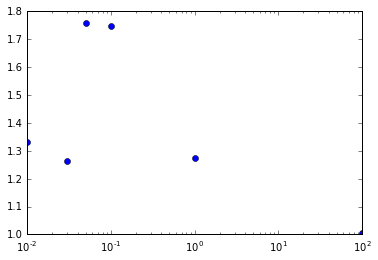

In [4]:
simdata=np.array([[0.01,0.0145,0.0109],[0.03, 0.0368,0.0291],[0.05,0.083695,0.0476],[0.1,0.1589,0.0909],[1,0.6365,0.5],[100,0.997,0.99]])
plt.semilogx(simdata[:,0],[x/y for x,y in zip(simdata[:,1],simdata[:,2])],'o')

In [7]:
0.0165/0.0099,0.156/0.0909

(1.6666666666666665, 1.7161716171617163)

In [6]:
[0.42/(1./p-1)/k for p,k in [(0.592,1.),(0.0126,0.01),(0.9952,100)]]

[0.6094117647058823, 0.535953007899534, 0.8707999999999886]

with multiprocessing

In [2]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,phic):
        L = 1.
        rm=0.005
        duration=int(L/rm/4)*100
        voxel_radius = rm*1.021
        D = 1.
        kD = 4 * math.pi * (2 * rm) * D
        ka = kD * kaf
        dt = (4 * voxel_radius * voxel_radius) / (6 * D)    
        maxt=dt*duration
        rng = GSLRandomNumberGenerator()  
        rng.seed(run)
        Nc=int(phic*L**3/(4*math.pi*rm**3 /3))
        with species_attributes():
            C | {'D':str(D),'radius':str(voxel_radius)}
            B | {'D':str(0),'radius':str(voxel_radius)}
            T | {'D':str(D),'radius':str(voxel_radius)}
        with reaction_rules():
            T + B >B | ka     
        m=get_model()           
        w = spatiocyte.SpatiocyteWorld(ones() * L, voxel_radius, rng)
        w.bind_to(m)       
        coord1 = w.position2coordinate(ones() * L * 0.5)
        coord2 = w.get_neighbor(coord1, 0)
        (pidB,p),suc=w.new_particle(Species('B'),w.coordinate2position(coord1))  
        (pidT,p),suc=w.new_particle(Species('T'),w.coordinate2position(coord2))     
        w.add_molecules(Species('C'),Nc)
        t= 0.0
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        pos = tuple(p.position())
        while all(0<= dim <L for dim in pos) and t<maxt:
            NT=w.num_particles(Species('T'))        
            if NT==0:
                return True
            else:
                (pid,p)=w.get_particle(pidT)
                pos = tuple(p.position())
                sim.step()
                t = sim.t()
        return False    
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

simrun=2000
nproc=70
phic=0.3
kafs=[0.01,100]
result=[('phic','kaf','pt','psim')]
for kaf in kafs:
    jobs=[{'kaf':kaf,'phic':phic}]
    res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
    #res=ensemble.run_sge(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]
    pt = 1./(1+1./kaf)
    print('kaf={},phic={},Prebtotal_theory{:.3}'.format(kaf,phic,pt))
    psim = float(res.count(True))/len(res)
    print('preb_sim',psim)  
    result.append((phic,kaf,pt,psim))


kaf=0.01,phic=0.3,Prebtotal_theory0.0099
preb_sim 0.0165
kaf=100,phic=0.3,Prebtotal_theory0.99
preb_sim 0.997


In [3]:
1./(1+1./100)

0.9900990099009901

In [ ]:
L,t,p
1,1e5,0.4
1,1e6,0.4
2,1e5,0.46
2,1e4,0.46
2,1e2,0.44
4,1e2,0.5

In [ ]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
import time

def singlerun(kaf,run,phic):
    rm=0.005
    L = 1.   
    duration=1e3
    voxel_radius = rm*1.021
    D = 1.
    kD = 4 * math.pi * (2 * rm) * D
    ka = kD * kaf
    Pacc = ka / (6 * math.sqrt(2) * D * voxel_radius)
    if (Pacc>1):
        alpha=1./Pacc
    else: alpha=1.
    assert Pacc*alpha <=1
    assert alpha  <= 1    
    dt = (4 * voxel_radius * voxel_radius) / (6 * D)    
    maxt=dt*duration
    rng = GSLRandomNumberGenerator()   
    rng.seed(run)
    Nc=int(phic*L**3/(4*math.pi*rm**3 /3))
    
    with species_attributes():
        C | {'D':str(D),'radius':str(voxel_radius)}
        T | {'D':str(0),'radius':str(voxel_radius)}
    m=get_model()           
    w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxel_radius, Integer3(3, 3, 3), rng)
    w.bind_to(m)        
    w.add_molecules(Species('C'),Nc)

    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)
    (pidT1,p),suc=w.new_particle(Species('T'),w.coordinate2position(coord2))   
    dt = dt*alpha
    t= 0.0
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    sim.set_dt(dt)
    
    while all(0<= dim <L for dim in w.coordinate2position(coord2)) and t<maxt:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)          
        if newcoord == coord1:
            if Pacc*alpha >= w.rng().uniform(0, 1):
                return True
        elif alpha>=w.rng().uniform(0,1):
            (pidT2,p),suc=w.new_particle(Species('T'),w.coordinate2position(newcoord))
            if suc:
                coord2 = newcoord
                w.remove_particle(pidT1)   
                pidT1=pidT2
        sim.step()
        t = sim.t()
    assert(w.num_particles(Species('T'))==1)
    return False

def wrap(job,job_id,task_id):
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

simrun=100
nproc=70
phic=0.01
kafs=[1.]
st=time.time()
for kaf in kafs:
    jobs=[{'kaf':kaf,'phic':phic}]
    res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc)[0]
    print('kaf={},phic={},Prebtotal_theory{:.3}'.format(kaf,phic,1./(1+1./kaf)))
    print('preb_sim',float(res.count(True))/len(res))    
print(time.time()-st)
#name='/home/chew/outputdata/LS3Dcrowd_Dt{}Dc{}phi{:.3}phit{:.3}Nt{}rm{:.3}L{}'.format(Dt,Dc,phi,phit,Nt,rv,L)
#f=open(name,'w')
#np.savetxt(name,np.column_stack([tt,msd]),delimiter=',')
#f.close()    

In [7]:
r=0.0025
D=[0.06,4]
kd=4*3.14*r*2*D[1]
ka=[0.04,0.1]
[k/kd for k in ka]

[0.1592356687898089, 0.39808917197452226]